In [1]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(project_root)
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    TrainingArguments,
    Trainer,
    GenerationConfig,
)
import torch

from utils_dev import save_model_and_history, evaluate_model, cer_score, plot_history
from trocr.utils.utils_inf import inference
# from OCR_VQA.data_preparation import VQAProcessor
from custom_dataset.data_preparation import CustomDataProcessor

c:\Users\Stas\anaconda3\envs\ocr_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Dataset preparation

In [ ]:
# TrOCRProcessor class wraps image processor class and tokenizer class
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
data_path = os.path.join(project_root, 'custom_dataset', 'texts_wiki')

data_processor = CustomDataProcessor(processor, data_path)
train_dataset, val_dataset, test_dataset, train_size = data_processor(dataset_batch_size=500, train_frac=0.95, val_frac=0.025)

# 2. Train

In [9]:
# Postprocessing functions

def preprocess_logits_for_metrics(logits, labels):
    output_ids = torch.argmax(logits[0], dim=-1)
    return output_ids, labels

def compute_metrics(eval_pred):
    output_ids, labels_ids = eval_pred
    words_predicted = processor.tokenizer.batch_decode(output_ids[0], skip_special_tokens=False)
    words_labels = processor.tokenizer.batch_decode(labels_ids, skip_special_tokens=False)
    return {'cer': cer_score.compute(predictions=words_predicted, references=words_labels)}

In [10]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-printed")

# Choosing a strategy for text generation
# All strategies can be found here: 
# https://huggingface.co/docs/transformers/v4.48.2/en/main_classes/text_generation#transformers.GenerationConfig

generation_config = GenerationConfig(
    num_beams=3,
    do_sample=True,
    decoder_start_token_id=processor.tokenizer.bos_token_id,
    pad_token_id=processor.tokenizer.pad_token_id,
)

model.generation_config = generation_config
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['enc

In [ ]:
# Define parameters

model_name = '08.02.25_100000_v1'
output_dir = f'checkpoints/{model_name}'
num_epochs = 4
batch_size = 8
max_steps = int((train_size / batch_size) * num_epochs)
eval_steps = logging_steps = 1000

training_hyperparams = TrainingArguments(
    output_dir=output_dir,
    eval_strategy='steps', # evaluate on eval_dataset every eval_steps
    eval_steps=eval_steps,
    eval_accumulation_steps=logging_steps,
    logging_steps=logging_steps, # update steps to perform before output logs
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # num_train_epochs=num_epochs,
    save_total_limit=1, # Save only last checkpoint
    load_best_model_at_end=True, # Save best model
    # metric_for_best_model=cer_score, # Metric to evaluate checnkpoints
    # greater_is_better=True,
    save_steps=10000,
    # logging_dir='trocr_checkpoints/logs',
    max_steps=max_steps, # Overrides num_train_epochs
    # fp16=True,
    fp16_full_eval=True,
)

In [ ]:
# Training the model

if not os.path.exists(output_dir):
    trainer = Trainer(
        model=model,
        args=training_hyperparams,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
        compute_metrics=compute_metrics,
        # processing_class=processor,
        # data_collator=...
    )
    trainer.train()
else:
    raise ValueError(f"Model '{model_name}' exists, specify anothe name")

max_steps is given, it will override any value given in num_train_epochs
  2%|▏         | 1000/47500 [08:33<59:29:18,  4.61s/it]

{'loss': 0.2195, 'grad_norm': 0.5917148590087891, 'learning_rate': 4.8947368421052635e-05, 'epoch': 0.02}


  2%|▏         | 1000/47500 [10:20<59:29:18,  4.61s/it]

{'eval_loss': 0.1477021425962448, 'eval_cer': 0.0208246106263826, 'eval_runtime': 107.5154, 'eval_samples_per_second': 23.252, 'eval_steps_per_second': 2.911, 'epoch': 0.02}


  4%|▍         | 2000/47500 [18:28<58:38:00,  4.64s/it] 

{'loss': 0.1481, 'grad_norm': 0.3253823220729828, 'learning_rate': 4.789473684210526e-05, 'epoch': 0.04}


  4%|▍         | 2000/47500 [20:15<58:38:00,  4.64s/it]

{'eval_loss': 0.13899070024490356, 'eval_cer': 0.019541269833630907, 'eval_runtime': 106.5826, 'eval_samples_per_second': 23.456, 'eval_steps_per_second': 2.937, 'epoch': 0.04}


  6%|▋         | 3000/47500 [28:19<57:37:59,  4.66s/it] 

{'loss': 0.1337, 'grad_norm': 0.42318597435951233, 'learning_rate': 4.68421052631579e-05, 'epoch': 0.06}


  6%|▋         | 3000/47500 [30:04<57:37:59,  4.66s/it]

{'eval_loss': 0.12936174869537354, 'eval_cer': 0.017958750218568978, 'eval_runtime': 104.3742, 'eval_samples_per_second': 23.952, 'eval_steps_per_second': 2.999, 'epoch': 0.06}


  8%|▊         | 4000/47500 [38:13<60:14:53,  4.99s/it] 

{'loss': 0.1278, 'grad_norm': 0.6233603954315186, 'learning_rate': 4.5789473684210527e-05, 'epoch': 0.08}


  8%|▊         | 4000/47500 [39:59<60:14:53,  4.99s/it]

{'eval_loss': 0.12124177068471909, 'eval_cer': 0.01663370085005286, 'eval_runtime': 105.2522, 'eval_samples_per_second': 23.752, 'eval_steps_per_second': 2.974, 'epoch': 0.08}


 11%|█         | 5000/47500 [48:08<57:10:18,  4.84s/it] 

{'loss': 0.1223, 'grad_norm': 0.5580134987831116, 'learning_rate': 4.473684210526316e-05, 'epoch': 0.11}


 11%|█         | 5000/47500 [49:52<57:10:18,  4.84s/it]

{'eval_loss': 0.11413369327783585, 'eval_cer': 0.015843644174515097, 'eval_runtime': 104.396, 'eval_samples_per_second': 23.947, 'eval_steps_per_second': 2.998, 'epoch': 0.11}


 13%|█▎        | 6000/47500 [57:58<55:46:02,  4.84s/it] 

{'loss': 0.1173, 'grad_norm': 0.8009687066078186, 'learning_rate': 4.368421052631579e-05, 'epoch': 0.13}


 13%|█▎        | 6000/47500 [59:39<55:46:02,  4.84s/it]

{'eval_loss': 0.1080000251531601, 'eval_cer': 0.015191546634198144, 'eval_runtime': 101.7221, 'eval_samples_per_second': 24.577, 'eval_steps_per_second': 3.077, 'epoch': 0.13}


 15%|█▍        | 7000/47500 [1:07:45<53:01:14,  4.71s/it]

{'loss': 0.1126, 'grad_norm': 0.41786688566207886, 'learning_rate': 4.2631578947368425e-05, 'epoch': 0.15}


 15%|█▍        | 7000/47500 [1:09:30<53:01:14,  4.71s/it]

{'eval_loss': 0.1034540981054306, 'eval_cer': 0.014083863112454341, 'eval_runtime': 104.9632, 'eval_samples_per_second': 23.818, 'eval_steps_per_second': 2.982, 'epoch': 0.15}


 17%|█▋        | 8000/47500 [1:17:39<52:07:15,  4.75s/it] 

{'loss': 0.1039, 'grad_norm': 0.9047149419784546, 'learning_rate': 4.157894736842106e-05, 'epoch': 0.17}


 17%|█▋        | 8000/47500 [1:19:24<52:07:15,  4.75s/it]

{'eval_loss': 0.09758657217025757, 'eval_cer': 0.013663569002828162, 'eval_runtime': 105.0061, 'eval_samples_per_second': 23.808, 'eval_steps_per_second': 2.981, 'epoch': 0.17}


 19%|█▉        | 9000/47500 [1:27:32<50:47:51,  4.75s/it] 

{'loss': 0.0972, 'grad_norm': 0.7814365029335022, 'learning_rate': 4.0526315789473684e-05, 'epoch': 0.19}


 19%|█▉        | 9000/47500 [1:29:18<50:47:51,  4.75s/it]

{'eval_loss': 0.09506873041391373, 'eval_cer': 0.013273754237029835, 'eval_runtime': 105.8209, 'eval_samples_per_second': 23.625, 'eval_steps_per_second': 2.958, 'epoch': 0.19}


 21%|██        | 10000/47500 [1:37:22<50:25:50,  4.84s/it]

{'loss': 0.0964, 'grad_norm': 0.5935781598091125, 'learning_rate': 3.9473684210526316e-05, 'epoch': 0.21}


 21%|██        | 10000/47500 [1:39:07<50:25:50,  4.84s/it]

{'eval_loss': 0.09057991951704025, 'eval_cer': 0.012357769746203317, 'eval_runtime': 104.9443, 'eval_samples_per_second': 23.822, 'eval_steps_per_second': 2.983, 'epoch': 0.21}


 23%|██▎       | 11000/47500 [1:47:19<50:14:22,  4.96s/it] 

{'loss': 0.0905, 'grad_norm': 0.5749087333679199, 'learning_rate': 3.842105263157895e-05, 'epoch': 0.23}


 23%|██▎       | 11000/47500 [1:49:03<50:14:22,  4.96s/it]

{'eval_loss': 0.0868326723575592, 'eval_cer': 0.012030517844051635, 'eval_runtime': 104.0493, 'eval_samples_per_second': 24.027, 'eval_steps_per_second': 3.008, 'epoch': 0.23}


 25%|██▌       | 12000/47500 [1:56:53<2:23:04,  4.14it/s]  

{'loss': 0.0853, 'grad_norm': 0.6495534181594849, 'learning_rate': 3.736842105263158e-05, 'epoch': 1.0}


 25%|██▌       | 12000/47500 [1:58:40<2:23:04,  4.14it/s]

{'eval_loss': 0.08555356413125992, 'eval_cer': 0.011518785702941898, 'eval_runtime': 106.1043, 'eval_samples_per_second': 23.562, 'eval_steps_per_second': 2.95, 'epoch': 1.0}


 27%|██▋       | 13000/47500 [2:07:10<2:22:09,  4.04it/s]  

{'loss': 0.0785, 'grad_norm': 1.1899014711380005, 'learning_rate': 3.6315789473684214e-05, 'epoch': 1.02}


 27%|██▋       | 13000/47500 [2:09:21<2:22:09,  4.04it/s]

{'eval_loss': 0.08195272088050842, 'eval_cer': 0.010900375858434678, 'eval_runtime': 131.4653, 'eval_samples_per_second': 19.016, 'eval_steps_per_second': 2.381, 'epoch': 1.02}


 29%|██▉       | 14000/47500 [2:18:09<2:16:08,  4.10it/s]  

{'loss': 0.0782, 'grad_norm': 0.7706192135810852, 'learning_rate': 3.526315789473684e-05, 'epoch': 1.04}


 29%|██▉       | 14000/47500 [2:20:08<2:16:08,  4.10it/s]

{'eval_loss': 0.08102453500032425, 'eval_cer': 0.010779260571118736, 'eval_runtime': 119.6204, 'eval_samples_per_second': 20.899, 'eval_steps_per_second': 2.617, 'epoch': 1.04}


 32%|███▏      | 15000/47500 [2:28:31<2:12:21,  4.09it/s]  

{'loss': 0.0725, 'grad_norm': 1.4752709865570068, 'learning_rate': 3.421052631578947e-05, 'epoch': 1.07}


 32%|███▏      | 15000/47500 [2:30:26<2:12:21,  4.09it/s]

{'eval_loss': 0.08325918018817902, 'eval_cer': 0.011481889655150287, 'eval_runtime': 114.2923, 'eval_samples_per_second': 21.874, 'eval_steps_per_second': 2.739, 'epoch': 1.07}


 34%|███▎      | 16000/47500 [2:38:53<2:08:19,  4.09it/s]  

{'loss': 0.0727, 'grad_norm': 0.6044995784759521, 'learning_rate': 3.3157894736842106e-05, 'epoch': 1.09}


 34%|███▎      | 16000/47500 [2:40:45<2:08:19,  4.09it/s]

{'eval_loss': 0.07719004899263382, 'eval_cer': 0.01050895691664541, 'eval_runtime': 112.6721, 'eval_samples_per_second': 22.188, 'eval_steps_per_second': 2.778, 'epoch': 1.09}


 36%|███▌      | 17000/47500 [2:49:10<2:03:35,  4.11it/s]  

{'loss': 0.0721, 'grad_norm': 0.2846356928348541, 'learning_rate': 3.210526315789474e-05, 'epoch': 1.11}


 36%|███▌      | 17000/47500 [2:51:00<2:03:35,  4.11it/s]

{'eval_loss': 0.07358653098344803, 'eval_cer': 0.009846432232387351, 'eval_runtime': 110.2726, 'eval_samples_per_second': 22.671, 'eval_steps_per_second': 2.838, 'epoch': 1.11}


 38%|███▊      | 18000/47500 [2:59:20<2:00:23,  4.08it/s]  

{'loss': 0.0702, 'grad_norm': 0.17785800993442535, 'learning_rate': 3.105263157894737e-05, 'epoch': 1.13}


 38%|███▊      | 18000/47500 [3:01:10<2:00:23,  4.08it/s]

{'eval_loss': 0.07190543413162231, 'eval_cer': 0.009544847146090704, 'eval_runtime': 109.9736, 'eval_samples_per_second': 22.733, 'eval_steps_per_second': 2.846, 'epoch': 1.13}


 40%|████      | 19000/47500 [3:09:27<1:57:26,  4.04it/s]  

{'loss': 0.0688, 'grad_norm': 0.7946082949638367, 'learning_rate': 3e-05, 'epoch': 1.15}


 40%|████      | 19000/47500 [3:11:19<1:57:26,  4.04it/s]

{'eval_loss': 0.07161575555801392, 'eval_cer': 0.009742962880971746, 'eval_runtime': 111.499, 'eval_samples_per_second': 22.422, 'eval_steps_per_second': 2.807, 'epoch': 1.15}


 42%|████▏     | 20000/47500 [3:19:30<1:51:11,  4.12it/s]  

{'loss': 0.0642, 'grad_norm': 0.6553056836128235, 'learning_rate': 2.8947368421052634e-05, 'epoch': 1.17}


 42%|████▏     | 20000/47500 [3:21:16<1:51:11,  4.12it/s]

{'eval_loss': 0.06808389723300934, 'eval_cer': 0.00926491843567174, 'eval_runtime': 105.5922, 'eval_samples_per_second': 23.676, 'eval_steps_per_second': 2.964, 'epoch': 1.17}


 44%|████▍     | 21000/47500 [3:29:22<1:47:14,  4.12it/s]  

{'loss': 0.0631, 'grad_norm': 1.2125062942504883, 'learning_rate': 2.7894736842105263e-05, 'epoch': 1.19}


 44%|████▍     | 21000/47500 [3:31:06<1:47:14,  4.12it/s]

{'eval_loss': 0.06800539791584015, 'eval_cer': 0.008983385549261839, 'eval_runtime': 104.1437, 'eval_samples_per_second': 24.005, 'eval_steps_per_second': 3.005, 'epoch': 1.19}


 46%|████▋     | 22000/47500 [3:39:12<1:42:58,  4.13it/s]  

{'loss': 0.0619, 'grad_norm': 0.18988844752311707, 'learning_rate': 2.6842105263157896e-05, 'epoch': 1.21}


 46%|████▋     | 22000/47500 [3:40:58<1:42:58,  4.13it/s]

{'eval_loss': 0.06529407948255539, 'eval_cer': 0.008640091887200762, 'eval_runtime': 106.1078, 'eval_samples_per_second': 23.561, 'eval_steps_per_second': 2.95, 'epoch': 1.21}


 48%|████▊     | 23000/47500 [3:49:04<1:40:13,  4.07it/s]  

{'loss': 0.0585, 'grad_norm': 2.300415515899658, 'learning_rate': 2.578947368421053e-05, 'epoch': 1.23}


 48%|████▊     | 23000/47500 [3:50:48<1:40:13,  4.07it/s]

{'eval_loss': 0.06476426124572754, 'eval_cer': 0.008676987934992372, 'eval_runtime': 104.294, 'eval_samples_per_second': 23.971, 'eval_steps_per_second': 3.001, 'epoch': 1.23}


 51%|█████     | 24000/47500 [3:58:56<1:34:46,  4.13it/s]  

{'loss': 0.0571, 'grad_norm': 1.454138994216919, 'learning_rate': 2.4736842105263158e-05, 'epoch': 2.01}


 51%|█████     | 24000/47500 [4:00:43<1:34:46,  4.13it/s]

{'eval_loss': 0.06721743196249008, 'eval_cer': 0.008880718285841704, 'eval_runtime': 106.7793, 'eval_samples_per_second': 23.413, 'eval_steps_per_second': 2.931, 'epoch': 2.01}


 53%|█████▎    | 25000/47500 [4:08:51<1:31:29,  4.10it/s]  

{'loss': 0.0552, 'grad_norm': 1.0563634634017944, 'learning_rate': 2.368421052631579e-05, 'epoch': 2.03}


 53%|█████▎    | 25000/47500 [4:10:37<1:31:29,  4.10it/s]

{'eval_loss': 0.06466303020715714, 'eval_cer': 0.008376204936691195, 'eval_runtime': 106.0745, 'eval_samples_per_second': 23.568, 'eval_steps_per_second': 2.951, 'epoch': 2.03}


 55%|█████▍    | 26000/47500 [4:18:42<1:27:23,  4.10it/s]  

{'loss': 0.0543, 'grad_norm': 0.9440482258796692, 'learning_rate': 2.2631578947368423e-05, 'epoch': 2.05}


 55%|█████▍    | 26000/47500 [4:20:26<1:27:23,  4.10it/s]

{'eval_loss': 0.06395259499549866, 'eval_cer': 0.008567101879613008, 'eval_runtime': 103.6648, 'eval_samples_per_second': 24.116, 'eval_steps_per_second': 3.019, 'epoch': 2.05}


 57%|█████▋    | 27000/47500 [4:28:33<1:23:07,  4.11it/s]  

{'loss': 0.0504, 'grad_norm': 1.0440146923065186, 'learning_rate': 2.1578947368421053e-05, 'epoch': 2.07}


 57%|█████▋    | 27000/47500 [4:30:18<1:23:07,  4.11it/s]

{'eval_loss': 0.06288450956344604, 'eval_cer': 0.008249475033406966, 'eval_runtime': 104.7447, 'eval_samples_per_second': 23.868, 'eval_steps_per_second': 2.988, 'epoch': 2.07}


 59%|█████▉    | 28000/47500 [4:38:19<1:19:20,  4.10it/s]  

{'loss': 0.0516, 'grad_norm': 0.12961123883724213, 'learning_rate': 2.0526315789473685e-05, 'epoch': 2.09}


 59%|█████▉    | 28000/47500 [4:40:02<1:19:20,  4.10it/s]

{'eval_loss': 0.062044959515333176, 'eval_cer': 0.007889337523441021, 'eval_runtime': 103.066, 'eval_samples_per_second': 24.256, 'eval_steps_per_second': 3.037, 'epoch': 2.09}


 61%|██████    | 29000/47500 [4:48:05<1:14:55,  4.12it/s]  

{'loss': 0.051, 'grad_norm': 1.9264194965362549, 'learning_rate': 1.9473684210526315e-05, 'epoch': 2.11}


 61%|██████    | 29000/47500 [4:49:51<1:14:55,  4.12it/s]

{'eval_loss': 0.06143537163734436, 'eval_cer': 0.008078630290371897, 'eval_runtime': 105.6086, 'eval_samples_per_second': 23.672, 'eval_steps_per_second': 2.964, 'epoch': 2.11}


 63%|██████▎   | 30000/47500 [4:57:57<1:11:08,  4.10it/s]  

{'loss': 0.0503, 'grad_norm': 0.3486025333404541, 'learning_rate': 1.8421052631578947e-05, 'epoch': 2.13}


 63%|██████▎   | 30000/47500 [4:59:43<1:11:08,  4.10it/s]

{'eval_loss': 0.061342138797044754, 'eval_cer': 0.00785885817961317, 'eval_runtime': 105.1273, 'eval_samples_per_second': 23.781, 'eval_steps_per_second': 2.977, 'epoch': 2.13}


 65%|██████▌   | 31000/47500 [5:07:49<1:20:16,  3.43it/s]  

{'loss': 0.0489, 'grad_norm': 0.6945362687110901, 'learning_rate': 1.736842105263158e-05, 'epoch': 2.15}


 65%|██████▌   | 31000/47500 [5:09:34<1:20:16,  3.43it/s]

{'eval_loss': 0.05900120362639427, 'eval_cer': 0.007551658477348233, 'eval_runtime': 105.2876, 'eval_samples_per_second': 23.744, 'eval_steps_per_second': 2.973, 'epoch': 2.15}


 67%|██████▋   | 32000/47500 [5:17:38<1:02:52,  4.11it/s]  

{'loss': 0.0452, 'grad_norm': 0.5652187466621399, 'learning_rate': 1.6315789473684213e-05, 'epoch': 2.17}


 67%|██████▋   | 32000/47500 [5:19:24<1:02:52,  4.11it/s]

{'eval_loss': 0.058507129549980164, 'eval_cer': 0.007547648037370884, 'eval_runtime': 105.924, 'eval_samples_per_second': 23.602, 'eval_steps_per_second': 2.955, 'epoch': 2.17}


 69%|██████▉   | 33000/47500 [5:27:31<59:00,  4.09it/s]    

{'loss': 0.0462, 'grad_norm': 1.946029782295227, 'learning_rate': 1.5263157894736842e-05, 'epoch': 2.19}


 69%|██████▉   | 33000/47500 [5:29:15<59:00,  4.09it/s]

{'eval_loss': 0.05759592726826668, 'eval_cer': 0.007475460117778601, 'eval_runtime': 103.4042, 'eval_samples_per_second': 24.177, 'eval_steps_per_second': 3.027, 'epoch': 2.19}


 72%|███████▏  | 34000/47500 [5:37:20<54:32,  4.13it/s]    

{'loss': 0.044, 'grad_norm': 0.9730441570281982, 'learning_rate': 1.4210526315789475e-05, 'epoch': 2.22}


 72%|███████▏  | 34000/47500 [5:39:06<54:32,  4.13it/s]

{'eval_loss': 0.056349609047174454, 'eval_cer': 0.007535616717438837, 'eval_runtime': 105.8031, 'eval_samples_per_second': 23.629, 'eval_steps_per_second': 2.958, 'epoch': 2.22}


 74%|███████▎  | 35000/47500 [5:47:16<50:36,  4.12it/s]    

{'loss': 0.0416, 'grad_norm': 1.5919768810272217, 'learning_rate': 1.3157894736842106e-05, 'epoch': 2.24}


 74%|███████▎  | 35000/47500 [5:49:00<50:36,  4.12it/s]

{'eval_loss': 0.0553455613553524, 'eval_cer': 0.007383219998299573, 'eval_runtime': 103.5483, 'eval_samples_per_second': 24.143, 'eval_steps_per_second': 3.023, 'epoch': 2.24}


 76%|███████▌  | 36000/47500 [5:57:09<46:31,  4.12it/s]    

{'loss': 0.0418, 'grad_norm': 0.5656554698944092, 'learning_rate': 1.2105263157894737e-05, 'epoch': 3.01}


 76%|███████▌  | 36000/47500 [5:58:47<46:31,  4.12it/s]

{'eval_loss': 0.0578753799200058, 'eval_cer': 0.007433751542014171, 'eval_runtime': 98.0548, 'eval_samples_per_second': 25.496, 'eval_steps_per_second': 3.192, 'epoch': 3.01}


 78%|███████▊  | 37000/47500 [6:06:53<42:31,  4.12it/s]   

{'loss': 0.0415, 'grad_norm': 2.6670234203338623, 'learning_rate': 1.1052631578947368e-05, 'epoch': 3.03}


 78%|███████▊  | 37000/47500 [6:08:36<42:31,  4.12it/s]

{'eval_loss': 0.0560736320912838, 'eval_cer': 0.007223604487201082, 'eval_runtime': 103.4933, 'eval_samples_per_second': 24.156, 'eval_steps_per_second': 3.024, 'epoch': 3.03}


 80%|████████  | 38000/47500 [6:16:44<38:28,  4.12it/s]   

{'loss': 0.0401, 'grad_norm': 2.996574878692627, 'learning_rate': 1e-05, 'epoch': 3.05}


 80%|████████  | 38000/47500 [6:18:27<38:28,  4.12it/s]

{'eval_loss': 0.054701097309589386, 'eval_cer': 0.007086447439975745, 'eval_runtime': 102.8795, 'eval_samples_per_second': 24.3, 'eval_steps_per_second': 3.042, 'epoch': 3.05}


 82%|████████▏ | 39000/47500 [6:26:31<34:21,  4.12it/s]   

{'loss': 0.0368, 'grad_norm': 0.7717219591140747, 'learning_rate': 8.947368421052632e-06, 'epoch': 3.07}


 82%|████████▏ | 39000/47500 [6:28:16<34:21,  4.12it/s]

{'eval_loss': 0.05439538136124611, 'eval_cer': 0.006913196432954267, 'eval_runtime': 105.0777, 'eval_samples_per_second': 23.792, 'eval_steps_per_second': 2.979, 'epoch': 3.07}


 84%|████████▍ | 40000/47500 [6:36:22<30:31,  4.10it/s]   

{'loss': 0.0385, 'grad_norm': 1.8897260427474976, 'learning_rate': 7.894736842105263e-06, 'epoch': 3.09}


 84%|████████▍ | 40000/47500 [6:38:07<30:31,  4.10it/s]

{'eval_loss': 0.05394577607512474, 'eval_cer': 0.006810529169534132, 'eval_runtime': 104.6511, 'eval_samples_per_second': 23.889, 'eval_steps_per_second': 2.991, 'epoch': 3.09}


 86%|████████▋ | 41000/47500 [6:46:19<26:18,  4.12it/s]   

{'loss': 0.0381, 'grad_norm': 0.4069565236568451, 'learning_rate': 6.842105263157896e-06, 'epoch': 3.11}


 86%|████████▋ | 41000/47500 [6:48:05<26:18,  4.12it/s]

{'eval_loss': 0.05346109718084335, 'eval_cer': 0.006726309930009802, 'eval_runtime': 106.1633, 'eval_samples_per_second': 23.549, 'eval_steps_per_second': 2.948, 'epoch': 3.11}


 88%|████████▊ | 42000/47500 [6:56:16<22:19,  4.11it/s]   

{'loss': 0.0371, 'grad_norm': 0.6221210956573486, 'learning_rate': 5.789473684210527e-06, 'epoch': 3.13}


 88%|████████▊ | 42000/47500 [6:58:01<22:19,  4.11it/s]

{'eval_loss': 0.05295175313949585, 'eval_cer': 0.006784862353679097, 'eval_runtime': 105.1031, 'eval_samples_per_second': 23.786, 'eval_steps_per_second': 2.978, 'epoch': 3.13}


 91%|█████████ | 43000/47500 [7:06:07<18:16,  4.11it/s]   

{'loss': 0.0361, 'grad_norm': 0.7679760456085205, 'learning_rate': 4.736842105263159e-06, 'epoch': 3.16}


 91%|█████████ | 43000/47500 [7:07:51<18:16,  4.11it/s]

{'eval_loss': 0.052366968244314194, 'eval_cer': 0.006633267722535304, 'eval_runtime': 103.8219, 'eval_samples_per_second': 24.08, 'eval_steps_per_second': 3.015, 'epoch': 3.16}


 93%|█████████▎| 44000/47500 [7:15:58<14:13,  4.10it/s]   

{'loss': 0.0338, 'grad_norm': 0.444068044424057, 'learning_rate': 3.6842105263157892e-06, 'epoch': 3.18}


 93%|█████████▎| 44000/47500 [7:17:44<14:13,  4.10it/s]

{'eval_loss': 0.05153394863009453, 'eval_cer': 0.0066108092586621495, 'eval_runtime': 106.1247, 'eval_samples_per_second': 23.557, 'eval_steps_per_second': 2.949, 'epoch': 3.18}


 95%|█████████▍| 45000/47500 [7:25:49<10:09,  4.10it/s]   

{'loss': 0.0349, 'grad_norm': 0.7835459113121033, 'learning_rate': 2.631578947368421e-06, 'epoch': 3.2}


 95%|█████████▍| 45000/47500 [7:27:35<10:09,  4.10it/s]

{'eval_loss': 0.0506952628493309, 'eval_cer': 0.006422318579726745, 'eval_runtime': 106.3494, 'eval_samples_per_second': 23.507, 'eval_steps_per_second': 2.943, 'epoch': 3.2}


 97%|█████████▋| 46000/47500 [7:35:42<06:04,  4.11it/s]   

{'loss': 0.0321, 'grad_norm': 0.9674206972122192, 'learning_rate': 1.5789473684210528e-06, 'epoch': 3.22}


 97%|█████████▋| 46000/47500 [7:37:23<06:04,  4.11it/s]

{'eval_loss': 0.050328440964221954, 'eval_cer': 0.006497714851300906, 'eval_runtime': 101.1976, 'eval_samples_per_second': 24.704, 'eval_steps_per_second': 3.093, 'epoch': 3.22}


 99%|█████████▉| 47000/47500 [7:45:31<02:01,  4.13it/s]   

{'loss': 0.032, 'grad_norm': 0.6781923770904541, 'learning_rate': 5.263157894736843e-07, 'epoch': 3.24}


 99%|█████████▉| 47000/47500 [7:47:14<02:01,  4.13it/s]

{'eval_loss': 0.049987271428108215, 'eval_cer': 0.006412693523781107, 'eval_runtime': 103.3101, 'eval_samples_per_second': 24.199, 'eval_steps_per_second': 3.03, 'epoch': 3.24}


100%|██████████| 47500/47500 [7:51:16<00:00,  1.68it/s]  

{'train_runtime': 28276.0326, 'train_samples_per_second': 13.439, 'train_steps_per_second': 1.68, 'train_loss': 0.0688585234792609, 'epoch': 3.25}


# 3. Save model and history

In [ ]:
save_model_and_history(model_name, trainer)

# 4. Evaluation and Inference

__1. Plot training history__

In [ ]:
epochs = [i['epoch'] for i in trainer.state.log_history if 'eval_cer' in i]
train_loss = [i['loss'] for i in trainer.state.log_history if 'loss' in i]
val_loss = [i['eval_loss'] for i in trainer.state.log_history if 'eval_loss' in i]
val_cer = [10 * i['eval_cer'] for i in trainer.state.log_history if 'eval_cer' in i]

hist = {'train_loss': train_loss, 'val_loss': val_loss, 'val_cer * 10': val_cer}

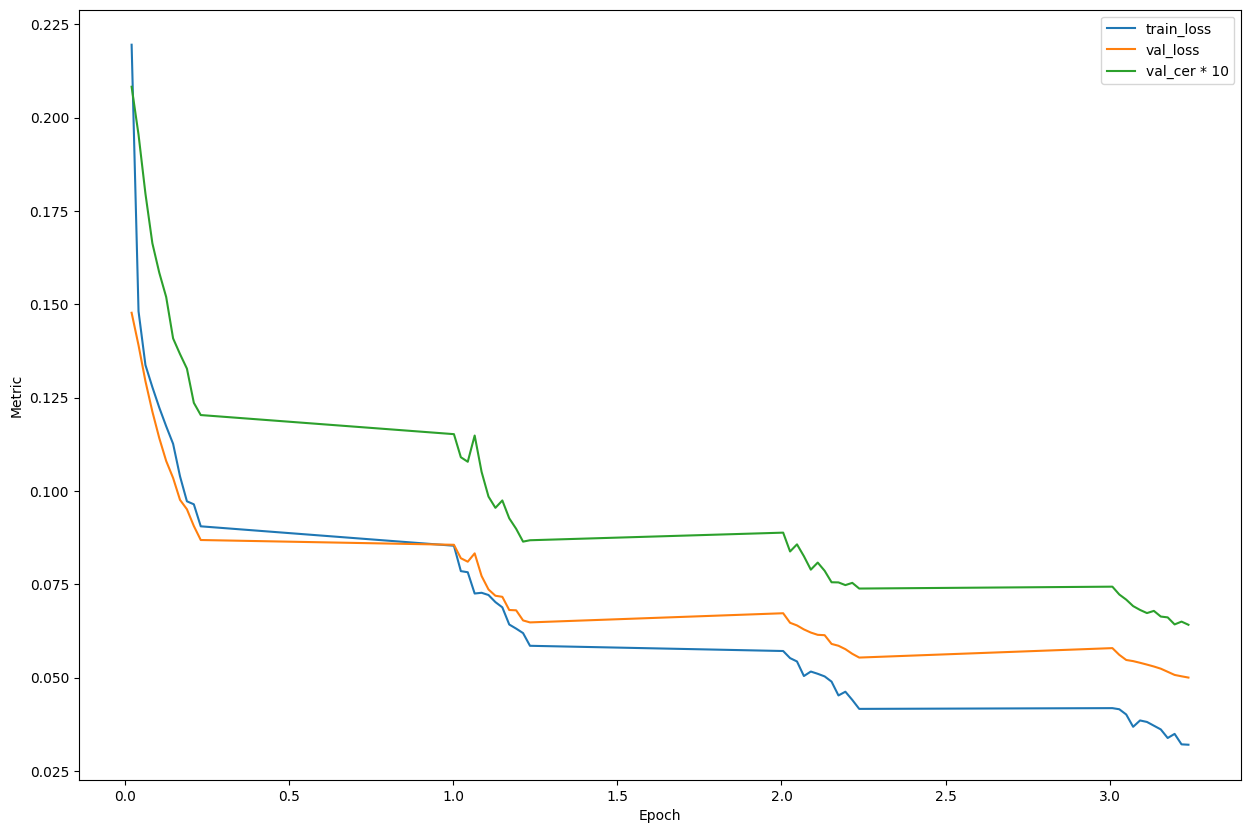

In [ ]:
plot_history(
    epochs,
    hist,
    run_name=model_name,
    figsize=(15, 10)
)

__2. Load model__

In [ ]:
model_name = '08.02.25_100000_v1'

model_path = f'models/{model_name}/model'

model = VisionEncoderDecoderModel.from_pretrained(model_path)
model = model.eval()

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


__3. Evaluate model on datasets__

In [ ]:
_, _, train_cer_value = evaluate_model(model, processor, train_dataset.dataset.indeces, cer_score, data_path=data_path)
train_cer_value

In [ ]:
_, _, val_cer_value = evaluate_model(model, processor, val_dataset.dataset.indeces, cer_score, data_path=data_path)
val_cer_value

0.22457222136580854

In [ ]:
_, _, test_cer_value = evaluate_model(model, processor, test_dataset.dataset.indeces, cer_score, data_path=data_path)
test_cer_value

0.22535642170960044

__4. Inference on new images__

In [ ]:
image_fold = os.path.join(project_root, 'test_images')

Involvement from the United States and the writing in the United States for the United States and the Legislative Minister's Democratic Administration, and the Legislative Administration, and Democratic Council of the Legislative Council of Representatives of Representatives, and Legislative Administration


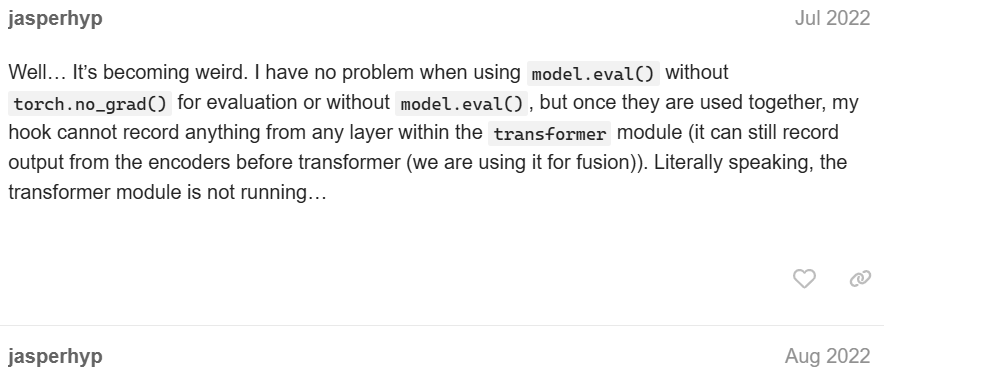

In [ ]:
img, text = inference(f'{image_fold}/test_screen.png', model, processor)
print(text)
img

<i>Re Limit the House of Representatives in the U.S. Ministers of the Minister of the Minister of the Minister of the Government of Administrative Administration of Representatives, and the Minister of Administrative Administration, and Administrative Administration, and the Legislative of Administrative Management of Administrative Administration, and the Minister of Administrative Administration, and Administrative Administration, and the Minister of Administrative Administration, and the Minister of Administrative Administration of Administrative Administration, and Municipal Administration, and Administrative Administration, and the Legislative, and the Minister of


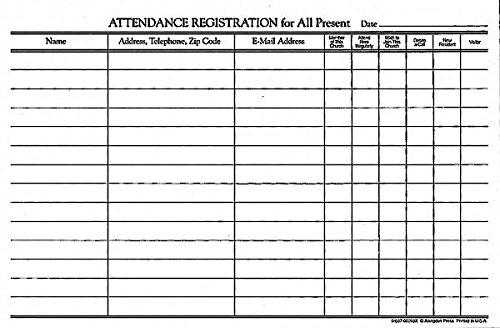

In [ ]:
img, text = inference(f'{image_fold}/one_channel_image.jpg', model, processor)
print(text)
img

<i>In the U.S. of the U.S. Minister of the World War II, and the World War II, and the War II, and the World War II, and the U.S., and the U.S.S., and the World War II, and the Legislative and the Legislative Minister, and the U., and the World War II, and I, and the War II, at the Legislative, and I, and the Legislative and the


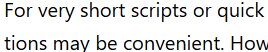

In [ ]:
img, text = inference(f'{image_fold}/test_screen_2.png', model, processor)
print(text)
img

__5. Inference on images from dataset__

In [ ]:
# image_fold = 'custom_dataset/data/images'
image_fold = os.path.join(data_path, 'images')

Life


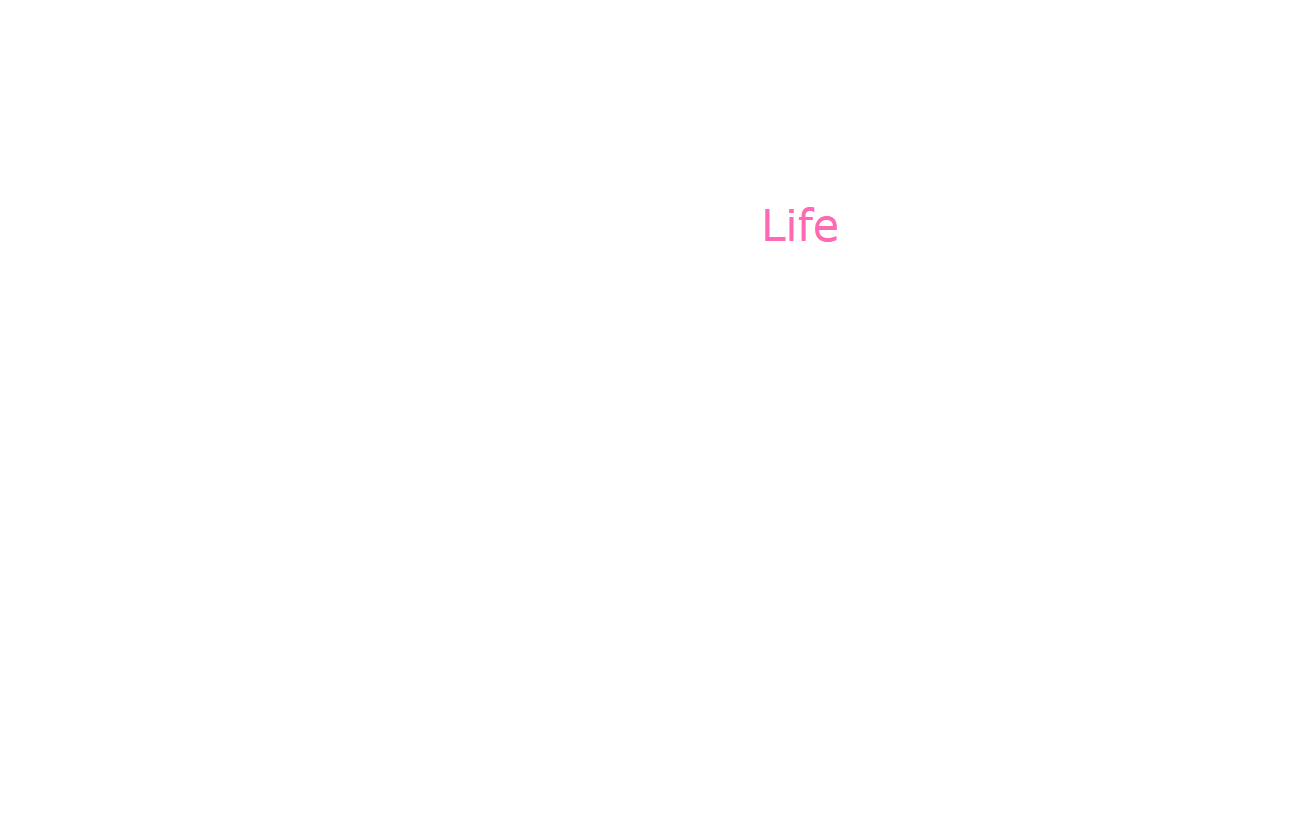

In [ ]:
idx = 2

img, text = inference(f'{image_fold}/image_{idx}.png', model, processor)
print(text)
img

Finals


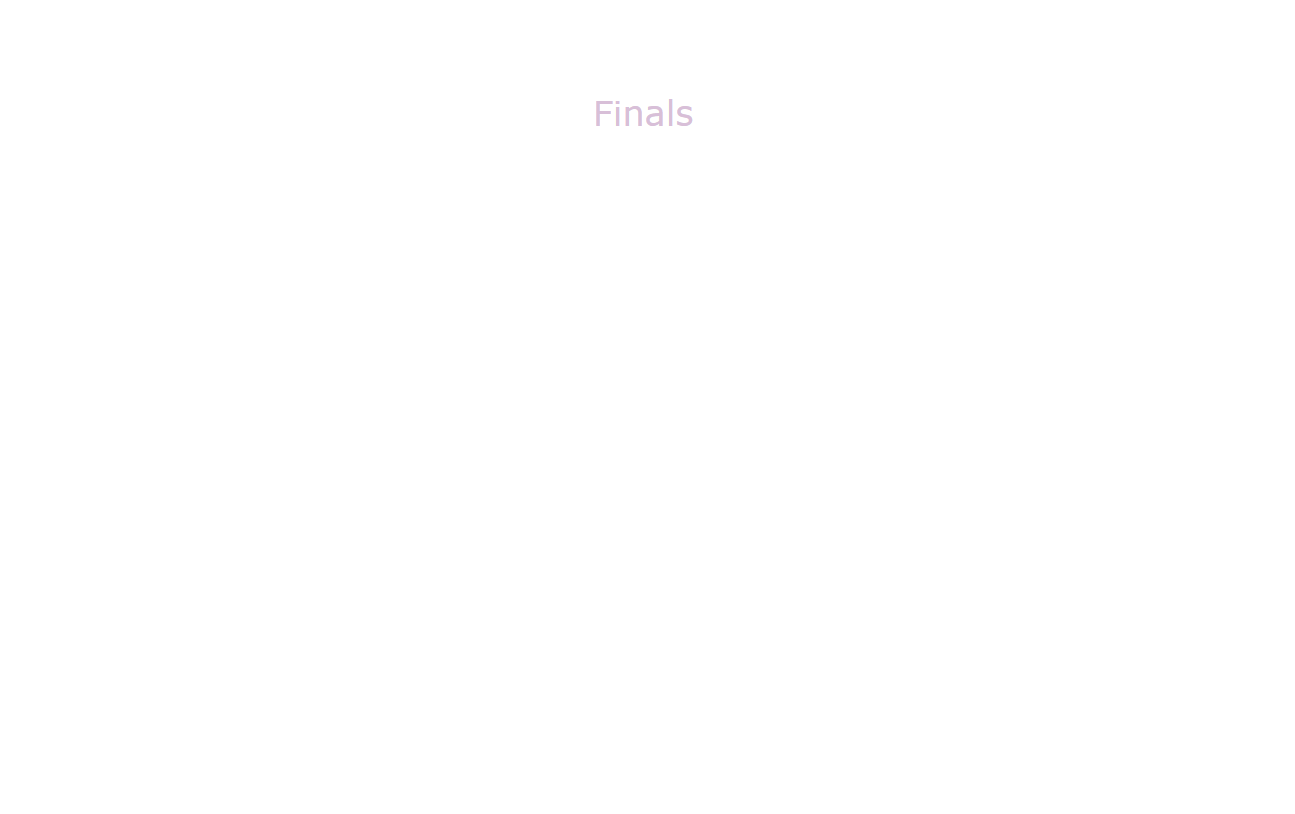

In [ ]:
idx = 35

img, text = inference(f'{image_fold}/image_{idx}.png', model, processor)
print(text)
img

References


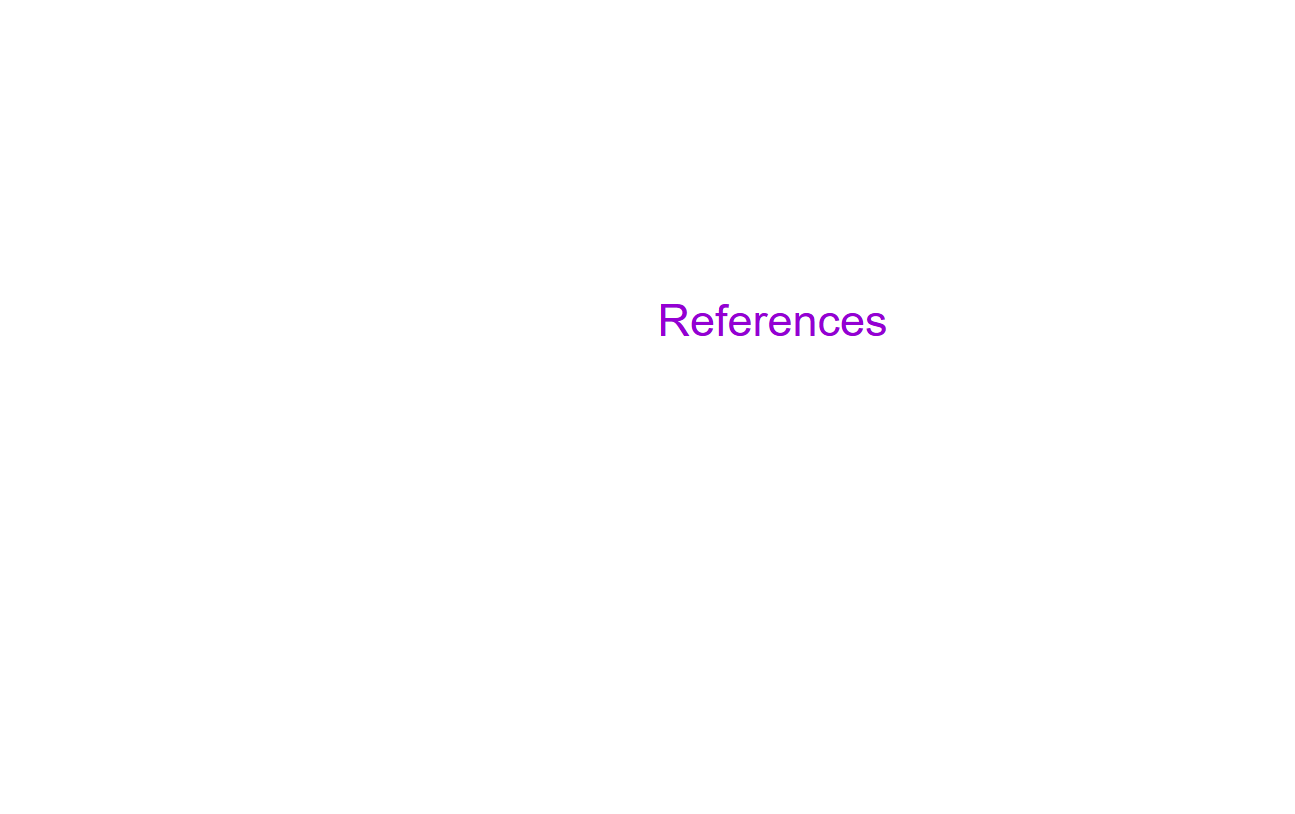

In [ ]:
idx = 1

img, text = inference(f'{image_fold}/image_{idx}.png', model, processor)
print(text)
img